# Verification example
In this example, we investigate the verification example from the xARPES manuscript examples section.

The notebook also contains an execution of the Bayesian loop with a set of parameters that is "far from" the optimal solution, similar to the supplemental section on the example.

In the future, functionality will be added to xARPES for users to generate their own mock example, allowing for testing of desired hypotheses. 

In [1]:
%load_ext autoreload
%autoreload 2

# Necessary packages
import xarpes
import numpy as np
import matplotlib.pyplot as plt
import os

# Default plot configuration from xarpes.plotting.py
xarpes.plot_settings('default')

In [2]:
script_dir = xarpes.set_script_dir()

dfld = 'data_sets'           # Folder containing the data
flnm = 'artificial_einstein' # Name of the file

In [3]:
angl = np.load(os.path.join(script_dir, dfld, "verification_angles.npy"))
ekns = np.load(os.path.join(script_dir, dfld, "verification_kinergies.npy"))
intn = np.load(os.path.join(script_dir, dfld, "verification_intensities.npy"))

In [4]:
bmap = xarpes.BandMap.from_np_arrays(intensities=intn, angles=angl, ekin=ekns,
        energy_resolution=0.0025, angle_resolution=0.1, temperature=10)

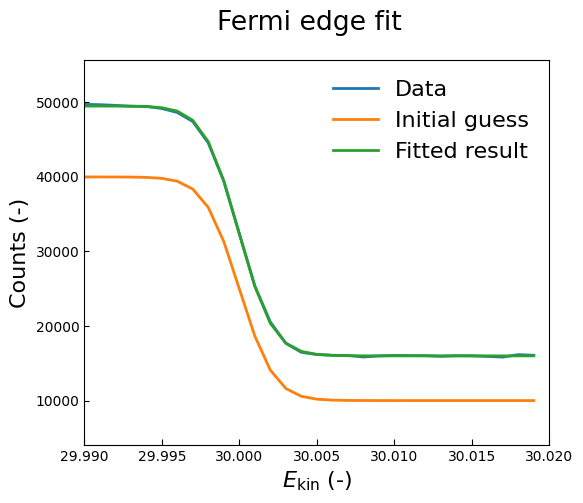

The optimised hnu - Phi=29.9999 +/- 0.00002 eV.


In [5]:
%matplotlib inline

fig = plt.figure(figsize=(6, 5)); ax = fig.gca()

fig = bmap.fit_fermi_edge(hnuminPhi_guess=30, background_guess=1e4,
                          integrated_weight_guess=3e4, angle_min=-6,
                          angle_max=10, ekin_min=29.99, ekin_max=30.02,
                          ax=ax, show=True, fig_close=True,
                          title='Fermi edge fit')

print('The optimised hnu - Phi=' + f'{bmap.hnuminPhi:.4f}' + ' +/- '
      + f'{1.96 * bmap.hnuminPhi_std:.5f}' + ' eV.')

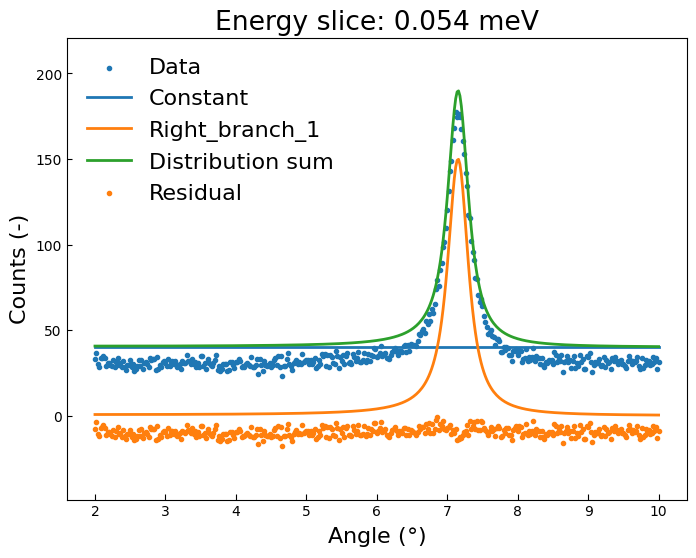

In [6]:
%matplotlib inline

angle_min = 2
angle_max = 10

energy_range = [-0.08, 0.0001]
energy_value = 0.0

k_0 = 0.1

mdcs = xarpes.MDCs(*bmap.mdc_set(angle_min, angle_max, energy_range=energy_range))

guess_dists = xarpes.CreateDistributions([
xarpes.Constant(offset=40),
xarpes.SpectralQuadratic(amplitude=0.25, peak=5.1, broadening=0.0005,
            center_wavevector=k_0, name='Right_branch', index='1')
])

fig = plt.figure(figsize=(8, 6)); ax = fig.gca()

fig = mdcs.visualize_guess(distributions=guess_dists, energy_value=energy_value, ax=ax)

**Note on interactive figures**
- The interactive figure might not work inside the Jupyter notebooks, despite our best efforts to ensure stability.
- As a fallback, the user may switch from "%matplotlib widget" to "%matplotlib qt", after which the figure should pop up in an external window.
- For some package versions, a static version of the interactive widget may spuriously show up inside other cells. In that case, uncomment the #get_ipython()... line in the first cell for your notebooks.

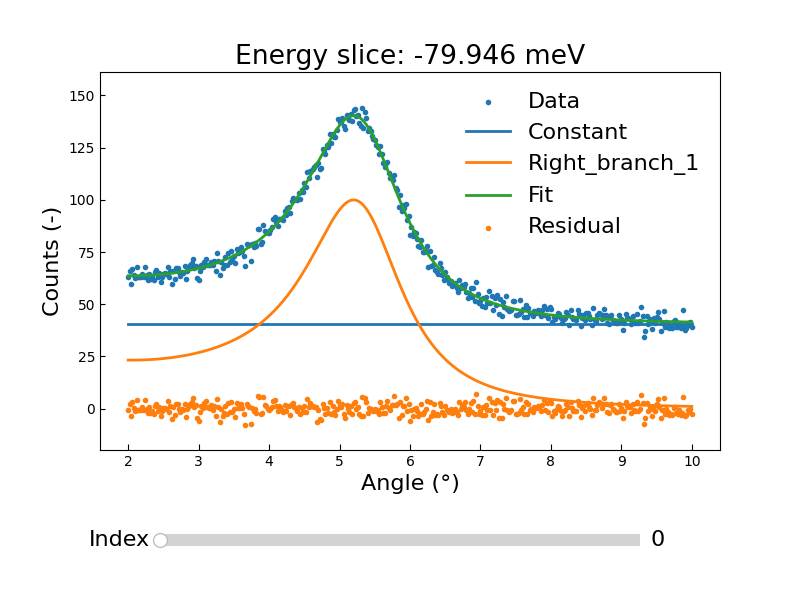

In [7]:
%matplotlib widget    

fig = plt.figure(figsize=(8, 6)); ax = fig.gca()

fig = mdcs.fit_selection(distributions=guess_dists, ax=ax)

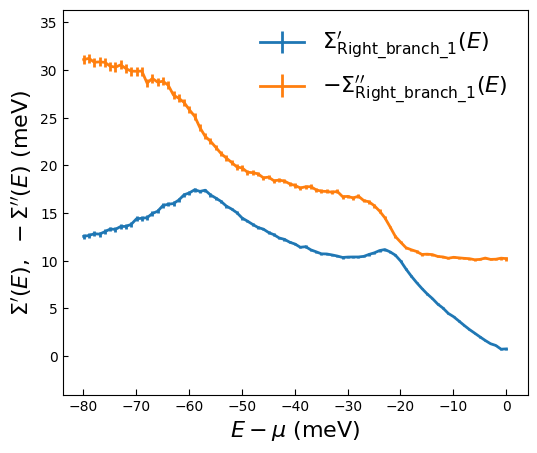

In [8]:
%matplotlib inline

fig = plt.figure(figsize=(6, 5)); ax = fig.gca()

self_energy = xarpes.SelfEnergy(*mdcs.expose_parameters(select_label='Right_branch_1', 
                                bare_mass=1.59675179, fermi_wavevector=0.2499758715, side='right'))

fig = self_energy.plot_both(ax=ax, scale='meV')

plt.show()

/home/tvanwaas/projects/xARPES/xarpes/plotting.py:72: UserWarning: Conversion from angle to momenta causes warping of the cell centers. 
 Cell edges of the mesh plot may look irregular.
  result = func(*args, **kwargs)


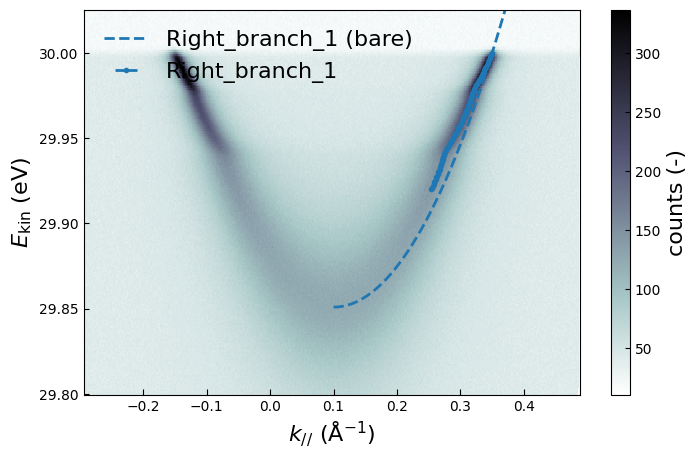

In [9]:
%matplotlib inline

self_energies = xarpes.CreateSelfEnergies([self_energy])

fig = plt.figure(figsize=(8, 5)); ax = fig.gca()

fig = bmap.plot(abscissa='momentum', ordinate='kinetic_energy', 
                plot_dispersions='domain', 
                self_energies=self_energies, ax=ax)

In the following cell, we extract the Eliashberg function from the self-energy. The result of the chi2kink fit is plotted during the extraction. Setting "show=False" and "fig_close=True" will prevent the figure from being displayed. Afterwards, the Eliashberg function and model function with the appropriate self-energy methods.

Dimensionality has been reduced from a matrix of rank 156 to 122 in the singular space.


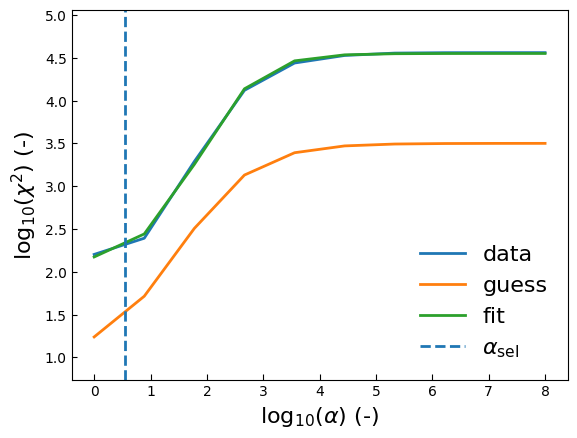

In [10]:
%matplotlib inline

fig, spectrum, model, omega_range, alpha_select = self_energy.extract_a2f(
    omega_min=1.0, omega_max=80, omega_num=250, omega_I=20, omega_M=60, 
    alpha_min=1.5, alpha_num=10, alpha_max=9.5, lambda_el=0.1132858, 
    impurity_magnitude=10.041243, h_n=0.0803366, show=True, fig_close=False)

plt.show()

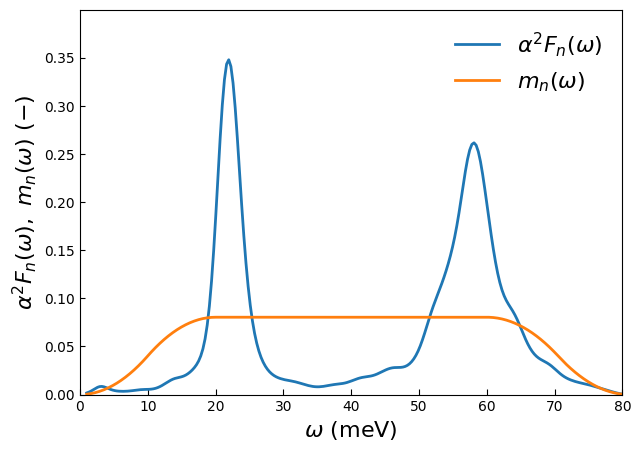

In [11]:
%matplotlib inline

fig = plt.figure(figsize=(7, 5)); ax = fig.gca()

fig = self_energy.plot_spectra(ax=ax)

plt.show()

The following plots all of the extracted quantities in a single figure. The default plotting range is taken from the second plotting statement.
By default, The Eliashberg function is extracted while removing the self-energies for binding energies smaller than the energy resolution. In that case, it is transparent to also eliminate these self-energies from the displayed result.

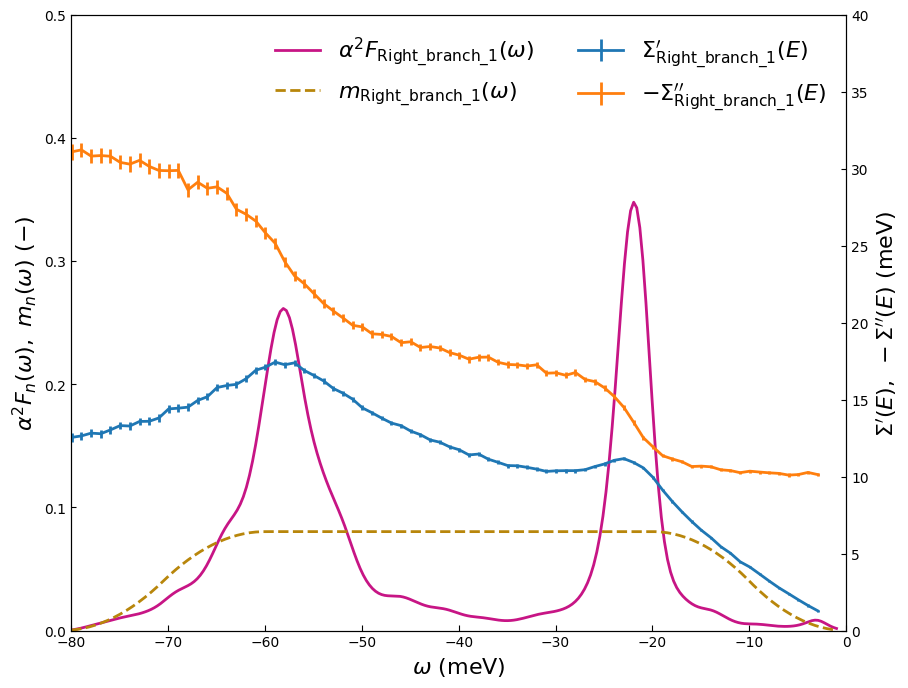

In [18]:
fig = plt.figure(figsize=(10, 8)); ax1 = fig.add_subplot(111); ax2 = ax1.twinx()

ax1.set_ylim([0, 0.5]); ax2.set_ylim([0, 40])

self_energy.plot_spectra( ax=ax1, abscissa="reversed", show=False, fig_close=False)
self_energy.plot_both(ax=ax2, scale="meV", resolution_range='applied', show=False, fig_close=False)

# --- spectra (ax1): last two lines
a2f_line, model_line = ax1.get_lines()[-2:]
a2f_line.set_color("mediumvioletred")
model_line.set_color("darkgoldenrod"); model_line.set_linestyle("--")

# --- self-energy lines (ax2): last two lines
real_line, imag_line = ax2.get_lines()[-2:]
real_line.set_color("tab:blue"); imag_line.set_color("tab:orange")

# --- match error bar colors to line colors
collections = ax2.collections

# Convention: real errorbars were added before imag errorbars
real_err, imag_err = collections[-2:]
real_err.set_color(real_line.get_color()); imag_err.set_color(imag_line.get_color())

# --- remove any pre-existing legends
for ax in (ax1, ax2): ax.get_legend() and ax.get_legend().remove()

# --- combined legend
h1, l1 = ax1.get_legend_handles_labels(); h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, ncol=2)

plt.show()

In the following cell, we start from the optimal solution. Unsurprisingly, the optimal solution is obtained after just a couple of iterations.

In [71]:
cost, spectrum, model, alpha_select = self_energy.bayesian_loop(omega_min=1.0,
            omega_max=80, omega_num=250, omega_I=20, omega_M=60,
            alpha_min=3.0, alpha_max=11.0, bare_mass=1.597636665, fermi_wavevector=0.2499774217, 
            h_n=0.081811739, impurity_magnitude=10.0379498, lambda_el=0.1054932517,
            vary=("impurity_magnitude", "lambda_el", "fermi_wavevector", "bare_mass", "h_n"), 
            scale_mb=0.01, scale_imp=0.1, scale_kF=0.001,
            scale_lambda_el=0.1, scale_hn=0.1)

Dimensionality has been reduced from a matrix of rank 156 to 122 in the singular space.
Iter    1 | cost = -5.1735e+02 | bare_mass=1.5976367 | fermi_wavevector=0.24997742 | h_n=0.081811739 | impurity_magnitude=10.03795 | lambda_el=0.10549325
Iter    2 | cost = -5.1735e+02 | bare_mass=1.5976367 | fermi_wavevector=0.24997742 | h_n=0.081811739 | impurity_magnitude=10.037975 | lambda_el=0.10549325
Iter    3 | cost = -5.1734e+02 | bare_mass=1.5976367 | fermi_wavevector=0.24997742 | h_n=0.081811739 | impurity_magnitude=10.03795 | lambda_el=0.10551825
Iter    4 | cost = -5.1735e+02 | bare_mass=1.5976367 | fermi_wavevector=0.24997767 | h_n=0.081811739 | impurity_magnitude=10.03795 | lambda_el=0.10549325
Iter    5 | cost = -5.1735e+02 | bare_mass=1.5976392 | fermi_wavevector=0.24997742 | h_n=0.081811739 | impurity_magnitude=10.03795 | lambda_el=0.10549325
Iter    6 | cost = -5.1734e+02 | bare_mass=1.5976367 | fermi_wavevector=0.24997742 | h_n=0.081836739 | impurity_magnitude=10.03795 | lambda_e

KeyboardInterrupt: 

In [ ]:

plt.figure(figsize=(9, 5))
plt.xlim([0, 80]); plt.ylim([0, 0.5])
plt.plot(omega_range, spectrum, color="mediumvioletred")
plt.plot(omega_range, model, color="tab:blue")
plt.xlabel(r'$\omega~$(meV)')
plt.ylabel(r'$\alpha^2F_n(\omega)~(-)$')
plt.show()

In the following cell, we start from a much less probable solution, showing that

The optimisation has been tested against Python v3.10.12, NumPy v2.2.6, and SciPy v1.15.3. Other combinations of these packages still have to be tested.

In [51]:
cost, spectrum, model, alpha_select, params = self_energy.bayesian_loop(omega_min=1.0,
            omega_max=80, omega_num=250, omega_I=20, omega_M=60,
            alpha_min=3.0, alpha_max=11.0, bare_mass=1.74625, fermi_wavevector=0.250125,
            h_n=0.09, impurity_magnitude=9.1, lambda_el=0.22, sigma_svd=0.1,
            vary=("impurity_magnitude", "lambda_el", "fermi_wavevector", "bare_mass", "h_n"), 
            converge_iters=100, tole=1e-8, scale_mb=0.1, scale_imp=1.0, scale_kF=0.001,
            scale_lambda_el=0.1, scale_hn=0.01)

Dimensionality has been reduced from a matrix of rank 156 to 58 in the singular space.
x0 params: {'impurity_magnitude': np.float64(9.1), 'lambda_el': np.float64(0.22), 'fermi_wavevector': 0.250125, 'bare_mass': 1.74625, 'h_n': np.float64(0.09)}
x0 out: 53786.005574786985 <class 'numpy.ndarray'> 7243.571212986861
Iter    1 | cost =  5.3786e+04 | bare_mass=1.74625 | fermi_wavevector=0.250125 | h_n=0.09 | impurity_magnitude=9.1 | lambda_el=0.22
Iter    2 | cost =  5.3786e+04 | bare_mass=1.74625 | fermi_wavevector=0.250125 | h_n=0.09 | impurity_magnitude=9.10025 | lambda_el=0.22
Iter    3 | cost =  5.3808e+04 | bare_mass=1.74625 | fermi_wavevector=0.250125 | h_n=0.09 | impurity_magnitude=9.1 | lambda_el=0.220025
Iter    4 | cost =  5.3779e+04 | bare_mass=1.74625 | fermi_wavevector=0.25012525 | h_n=0.09 | impurity_magnitude=9.1 | lambda_el=0.22
Iter    5 | cost =  5.3806e+04 | bare_mass=1.746275 | fermi_wavevector=0.250125 | h_n=0.09 | impurity_magnitude=9.1 | lambda_el=0.22
Iter    6 | co

KeyboardInterrupt: 

Following the recommended procedure, we perform a final optimisation with very tight criteria, for the purpose of further narrowing down the solution.

The solution should be marginally closer to the true solution for bare_mass, impurity_magnitude, and lambda_el.

In [28]:
cost, spectrum, model, alpha_select, params = self_energy.bayesian_loop(omega_min=1.0,
            omega_max=80, omega_num=250, omega_I=20, omega_M=60,
            alpha_min=1.0, alpha_max=9.0, sigma_svd=1e-4,
            bare_mass=1.597636093, fermi_wavevector=0.2499774208, 
            h_n=0.08181151626, impurity_magnitude=10.03795642, lambdxa_el=0.1054945571,
            vary=("impurity_magnitude", "lambda_el", "fermi_wavevector", "bare_mass", "h_n"), 
            converge_iters=100, tole=1e-8, scale_mb=0.1, scale_imp=0.1, scale_kF=0.01,
            scale_lambda_el=0.1, scale_hn=0.1)

Dimensionality has been reduced from a matrix of rank 156 to 122 in the singular space.
Iter    1 | cost = -4.4650e+02 | bare_mass=1.5976361 | fermi_wavevector=0.24997742 | h_n=0.081811516 | impurity_magnitude=10.037956 | lambda_el=0.10549456
Iter    2 | cost = -4.4650e+02 | bare_mass=1.5976361 | fermi_wavevector=0.24997742 | h_n=0.081811516 | impurity_magnitude=10.037981 | lambda_el=0.10549456
Iter    3 | cost = -4.4654e+02 | bare_mass=1.5976361 | fermi_wavevector=0.24997742 | h_n=0.081811516 | impurity_magnitude=10.037956 | lambda_el=0.10551956
Iter    4 | cost = -4.4606e+02 | bare_mass=1.5976361 | fermi_wavevector=0.24997992 | h_n=0.081811516 | impurity_magnitude=10.037956 | lambda_el=0.10549456
Iter    5 | cost = -4.4648e+02 | bare_mass=1.5976611 | fermi_wavevector=0.24997742 | h_n=0.081811516 | impurity_magnitude=10.037956 | lambda_el=0.10549456
Iter    6 | cost = -4.4665e+02 | bare_mass=1.5976361 | fermi_wavevector=0.24997742 | h_n=0.081836516 | impurity_magnitude=10.037956 | lam

KeyboardInterrupt: 